Name: Kushal Amara Chandrashekar
<br>
Github Username: kushalac
<br>
USC ID: 2595105884

In [14]:
from keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
import numpy as np

## (b) Data Exploration and Pre-processing

#### Images in each class are given in separate folders in the training and test sets. You can encode your classes using one-hot encoding.

####  To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

#### Use ReLU activation functions in the last layer and a softmax layer, along with regularization, batch normalization , and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable

In [15]:
# reference used: https://stackoverflow.com/questions/70080062/how-to-correctly-use-imagedatagenerator-in-keras
# reference used: https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
train_aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    validation_split=0.2
)
validation_aug = ImageDataGenerator(
    validation_split=0.2
)
test_aug = ImageDataGenerator(
)

#### ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV

In [16]:
#reference used: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
training_dataset='../data/seg_train'
testing_dataset='../data/seg_test'
image_size = (224, 224)
training_data = train_aug.flow_from_directory(
    directory=training_dataset,
    target_size=image_size,
    batch_size=16,
    class_mode='categorical',
    subset="training",
    seed=42
)

validation_data = validation_aug.flow_from_directory(
    directory=training_dataset,
    target_size=image_size,
    batch_size=16,
    class_mode='categorical',
    subset="validation",
    seed=42
)

test_data = test_aug.flow_from_directory(
    directory=testing_dataset,
    target_size=image_size,
    batch_size=16,
    class_mode='categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### (c) Transfer Learning

In [18]:
# reference used: https://keras.io/guides/sequential_model/
# reference used: https://keras.io/api/callbacks/model_checkpoint/
# reference used: https://keras.io/api/callbacks/early_stopping/
# reference used: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
from tensorflow.keras.models import Model,Sequential
def build_model(model):
  model.trainable = False
  required_model = Sequential(
      [
          model,
          GlobalAveragePooling2D(name="avg_pool"),
          BatchNormalization(),
          Dropout(0.2),
          Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
          BatchNormalization(),
          Dropout(0.2),
          Dense(training_data.num_classes, activation='softmax')
      ]
  )
  required_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
  with tf.device('/GPU:0'):
    history = required_model.fit(
      training_data,
      epochs=50,
      validation_data=validation_data,
      callbacks=[early_stopping, checkpoint],
      verbose=1
    )
  return required_model, history

In [96]:
def training_validation_plot(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('training and validation accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='validation Loss')
    plt.title('training and validation loss')
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [19]:
# reference used: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html
# reference used: https://stackoverflow.com/questions/66127619/understanding-of-classification-report-generated-from-my-model
#reference used: https://stackoverflow.com/questions/64022895/tf-keras-utils-to-categorical-mixing-classes
#chatgpt prompt: how to get label names directly from dataset
def evaluate_metrix(model, dataset, model_type, batch_size=16):
    num_images = dataset.samples
    num_batches = num_images // batch_size 
    if num_images % batch_size != 0:
        num_batches += 1
    true_labels_list = []
    predicted_labels_list = []
    predictions_list = []
    for _ in range(num_batches):
        images, true_labels = next(dataset)
        predictions = model.predict(images, verbose=0)
        predicted_labels = np.argmax(predictions, axis=1)
        true_classes = np.argmax(true_labels, axis=1)
        true_labels_list.extend(true_classes)
        predicted_labels_list.extend(predicted_labels)
        predictions_list.extend(predictions)   
    true_labels_list = np.array(true_labels_list)
    predicted_labels_list = np.array(predicted_labels_list)
    predictions_list = np.array(predictions_list)
    predicted_one_hot = to_categorical(true_labels_list, num_classes=dataset.num_classes)
    label_names = list(dataset.class_indices.keys())
    print(f"{model_type} Classification Report:")
    print(classification_report(true_labels_list, predicted_labels_list, target_names=label_names))
    auc_score = roc_auc_score(predicted_one_hot, predictions_list, multi_class='ovr')
    print(f"{model_type} AUC: {auc_score}\n")

#### iv Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 696s 973ms/step - accuracy: 0.7616 - loss: 3.7710 - val_accuracy: 0.8720 - val_loss: 1.1003
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.8216 - loss: 1.1471 - val_accuracy: 0.8566 - val_loss: 0.9158
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 793s 1s/step - accuracy: 0.8252 - loss: 0.9864 - val_accuracy: 0.8745 - val_loss: 0.8217
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 683s 972ms/step - accuracy: 0.8294 - loss: 0.9614 - val_accuracy: 0.8834 - val_loss: 0.7937
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.8312 - loss: 0.9455 - val_accuracy: 0.8730 - val_loss: 0.8205
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - accuracy: 0.8172 - loss: 0.9699 - val_accuracy: 0.8659 - val_loss: 0.8319
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.8229 - loss: 0.9532 - val_accuracy: 0.8869 - val_loss: 0.7276
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 697s 993ms/step - accuracy: 0.8186 - loss: 0.9236 -

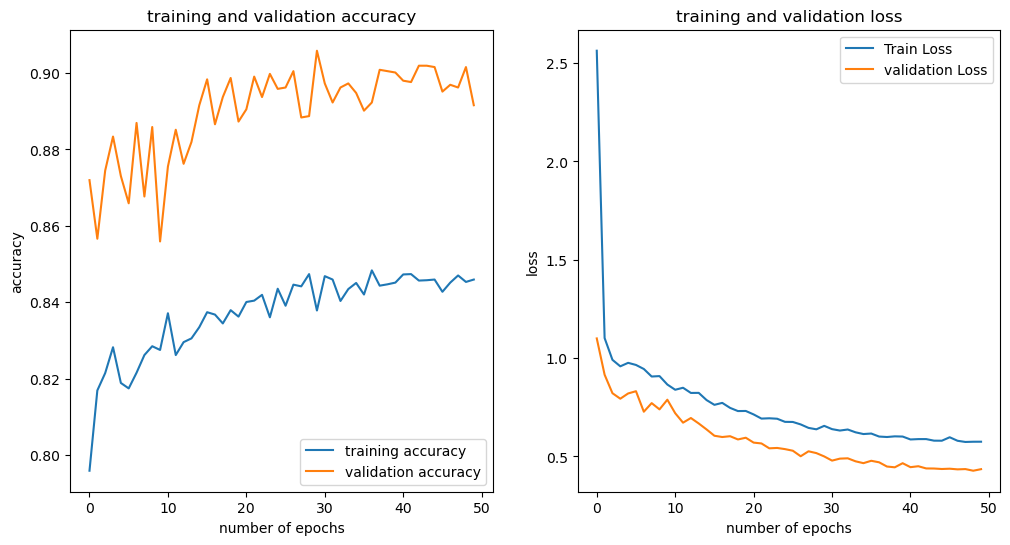

In [10]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_final_model, resnet50_history = build_model(resnet50_model)
training_validation_plot(resnet50_history)

#### v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem

In [80]:
evaluate_metrix(resnet50_final_model, training_data, "Training")
evaluate_metrix(resnet50_final_model, validation_data, "Validation")
evaluate_metrix(resnet50_final_model, test_data, "Test")

Training Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.90      0.91      1777
      forest       0.98      0.98      0.98      1800
     glacier       0.86      0.80      0.83      1894
    mountain       0.84      0.84      0.84      2055
         sea       0.87      0.92      0.89      1846
      street       0.89      0.93      0.91      1858

    accuracy                           0.89     11230
   macro avg       0.89      0.89      0.89     11230
weighted avg       0.89      0.89      0.89     11230

Training AUC: 0.9881897545950382

Validation Classification Report:
              precision    recall  f1-score   support

   buildings       0.95      0.92      0.93       451
      forest       0.98      0.98      0.98       439
     glacier       0.86      0.80      0.83       462
    mountain       0.84      0.86      0.85       505
         sea       0.89      0.92      0.91       459
      street       0.92      0.9

Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 206s 265ms/step - accuracy: 0.7639 - loss: 3.7406 - val_accuracy: 0.8691 - val_loss: 1.0899
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 157s 222ms/step - accuracy: 0.8184 - loss: 1.1134 - val_accuracy: 0.8866 - val_loss: 0.8327
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 154s 217ms/step - accuracy: 0.8321 - loss: 0.9516 - val_accuracy: 0.8584 - val_loss: 0.8888
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 153s 216ms/step - accuracy: 0.8237 - loss: 0.9497 - val_accuracy: 0.8570 - val_loss: 0.8502
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 156s 221ms/step - accuracy: 0.8291 - loss: 0.9449 - val_accuracy: 0.8834 - val_loss: 0.8019
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 155s 219ms/step - accuracy: 0.8253 - loss: 0.9360 - val_accuracy: 0.8837 - val_loss: 0.7840
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 154s 218ms/step - accuracy: 0.8184 - loss: 0.9388 - val_accuracy: 0.8809 - val_loss: 0.8073
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 156s 220ms/step - accuracy: 0.8293 -

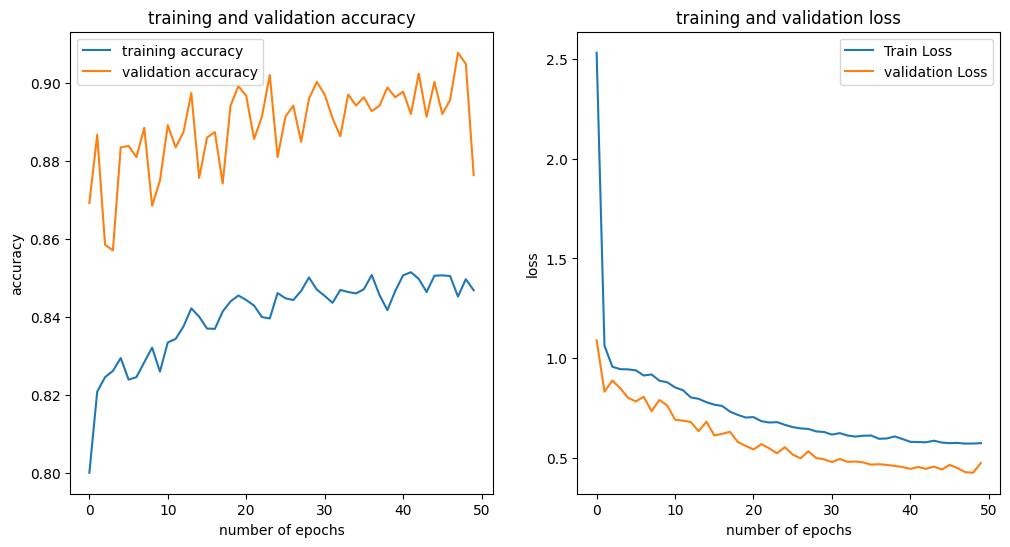

In [20]:
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet101_final_model, resnet101_history = build_model(resnet101_model)
training_validation_plot(resnet101_history)

In [21]:
evaluate_metrix(resnet101_final_model, training_data, "Training")
evaluate_metrix(resnet101_final_model, validation_data, "Validation")
evaluate_metrix(resnet101_final_model, test_data, "Test")

Training Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.91      0.91      1753
      forest       0.97      0.98      0.98      1817
     glacier       0.85      0.80      0.82      1924
    mountain       0.82      0.86      0.84      2010
         sea       0.91      0.90      0.90      1820
      street       0.91      0.93      0.92      1906

    accuracy                           0.89     11230
   macro avg       0.90      0.89      0.89     11230
weighted avg       0.89      0.89      0.89     11230

Training AUC: 0.9881327005013776

Validation Classification Report:
              precision    recall  f1-score   support

   buildings       0.96      0.89      0.92       438
      forest       0.99      0.97      0.98       454
     glacier       0.87      0.79      0.83       480
    mountain       0.81      0.88      0.85       502
         sea       0.92      0.93      0.93       454
      street       0.90      0.9

Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 542s 746ms/step - accuracy: 0.7889 - loss: 3.4409 - val_accuracy: 0.9058 - val_loss: 0.8838
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 596s 849ms/step - accuracy: 0.8599 - loss: 0.9108 - val_accuracy: 0.8866 - val_loss: 0.7011
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 551s 785ms/step - accuracy: 0.8619 - loss: 0.7707 - val_accuracy: 0.9044 - val_loss: 0.6597
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 393s 560ms/step - accuracy: 0.8634 - loss: 0.7445 - val_accuracy: 0.8887 - val_loss: 0.6606
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 421s 600ms/step - accuracy: 0.8610 - loss: 0.7380 - val_accuracy: 0.9062 - val_loss: 0.6084
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 426s 606ms/step - accuracy: 0.8650 - loss: 0.7422 - val_accuracy: 0.8994 - val_loss: 0.6281
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 435s 620ms/step - accuracy: 0.8652 - loss: 0.7230 - val_accuracy: 0.9051 - val_loss: 0.5992
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 352s 501ms/step - accuracy: 0.8672 -

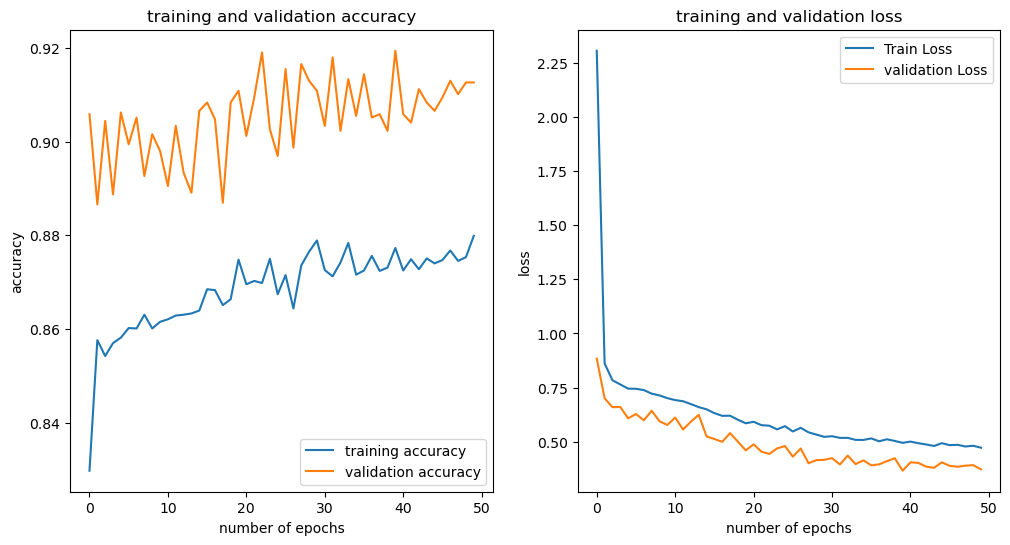

In [99]:
efficientnetb0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnetb0_final_model, efficientnetb0_history = build_model(efficientnetb0_model)
training_validation_plot(efficientnetb0_history)

In [100]:
evaluate_metrix(efficientnetb0_final_model, training_data, "Training")
evaluate_metrix(efficientnetb0_final_model, validation_data, "Validation")
evaluate_metrix(efficientnetb0_final_model, test_data, "Test")

Training Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92      1753
      forest       0.98      0.99      0.99      1817
     glacier       0.86      0.84      0.85      1924
    mountain       0.86      0.88      0.87      2010
         sea       0.95      0.93      0.94      1820
      street       0.92      0.94      0.93      1906

    accuracy                           0.91     11230
   macro avg       0.92      0.92      0.92     11230
weighted avg       0.91      0.91      0.91     11230

Training AUC: 0.9918574518676366

Validation Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92       421
      forest       1.00      0.99      1.00       450
     glacier       0.84      0.85      0.85       482
    mountain       0.87      0.84      0.85       502
         sea       0.95      0.97      0.96       457
      street       0.93      0.9

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 181s 237ms/step - accuracy: 0.7086 - loss: 3.3216 - val_accuracy: 0.8591 - val_loss: 1.2328
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 152s 214ms/step - accuracy: 0.7919 - loss: 1.2190 - val_accuracy: 0.8474 - val_loss: 0.7840
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 151s 213ms/step - accuracy: 0.8049 - loss: 0.8706 - val_accuracy: 0.8666 - val_loss: 0.6842
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 150s 212ms/step - accuracy: 0.7945 - loss: 0.8407 - val_accuracy: 0.8641 - val_loss: 0.6493
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 151s 213ms/step - accuracy: 0.8067 - loss: 0.7865 - val_accuracy: 0.8752 - val_loss: 0.6205
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 151s 213ms/step - accuracy: 0.8060 - loss: 0.7886 - val_accuracy: 0.8677 - val_loss: 0.6316
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 152s 215ms/step - accuracy: 0.8005 - loss: 0.7992 - val_accuracy: 0.8759 - val_loss: 0.6194
Epoch 8/50
702/702 ━━━━━━

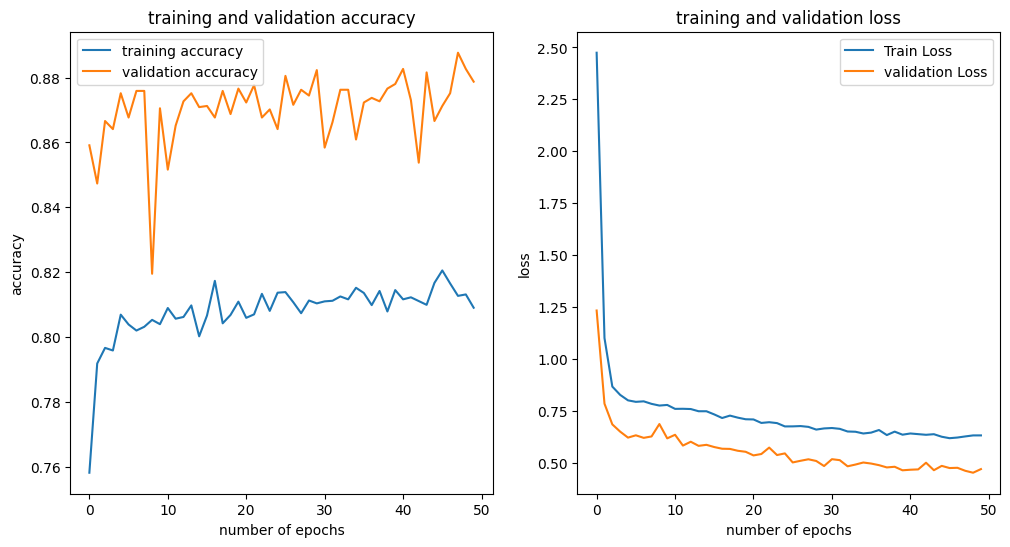

In [22]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_final_model, vgg16_history = build_model(vgg16_model)
training_validation_plot(vgg16_history)

In [23]:
evaluate_metrix(vgg16_final_model, training_data, "Training")
evaluate_metrix(vgg16_final_model, validation_data, "Validation")
evaluate_metrix(vgg16_final_model, test_data, "Test")

Training Classification Report:
              precision    recall  f1-score   support

   buildings       0.88      0.90      0.89      1753
      forest       0.97      0.98      0.98      1817
     glacier       0.84      0.77      0.80      1924
    mountain       0.79      0.83      0.81      2010
         sea       0.86      0.89      0.88      1820
      street       0.91      0.89      0.90      1906

    accuracy                           0.87     11230
   macro avg       0.88      0.88      0.88     11230
weighted avg       0.87      0.87      0.87     11230

Training AUC: 0.9851655131836455

Validation Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.91      0.91       438
      forest       0.99      0.97      0.98       454
     glacier       0.81      0.76      0.79       480
    mountain       0.80      0.80      0.80       502
         sea       0.89      0.93      0.91       454
      street       0.90      0.9

Best model is efficientnetb0 with test accuracy of 0.92